In [7]:
import pandas as pd 
import numpy as np
import re
from nltk import *
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

In [8]:
data = pd.read_csv("emails_as_txt_1200.csv") 
text = np.array(data['Email Text'])
data["From"] = [(lambda x: re.findall("(?<=@)[^.]+(?=\.)", x))(x)[0] for x in data["From"]]
data["To"] = [(lambda x: re.findall("(?<=@)[^.]+(?=\.)", x))(x) for x in data["To"]]
data.head()

,From,To,Subject,Date & Time Received,PDF Email Body Link,Email Text,Related
0,google,[berkeley],"The best of Gmail, wherever you are",5/1/18,https://drive.google.com/a/berkeley.edu/file/d...,Hi Rachit\n\nGet the official Gmail app\n\nThe...,0
1,google,[berkeley],Tips for using your new inbox,5/1/18,https://drive.google.com/a/berkeley.edu/file/d...,Hi Rachit\n\nWelcome to your Gmail inbox\n\nSa...,0
2,berkeley,[lists],Report of the Free Speech Commission,5/2/18,https://drive.google.com/a/berkeley.edu/file/d...,"Dear campus community,\n\nI am delighted to sh...",0
3,berkeley,[berkeley],Fall 2018 SHIP Benefits and Waiver Info,5/3/18,https://drive.google.com/a/berkeley.edu/file/d...,"As a non-academic condition of enrollment, you...",0
4,berkeley,[berkeley],California Residence for Tuition Purposes,5/3/18,https://drive.google.com/a/berkeley.edu/file/d...,"May 3, 2018\nRE: California R...",0


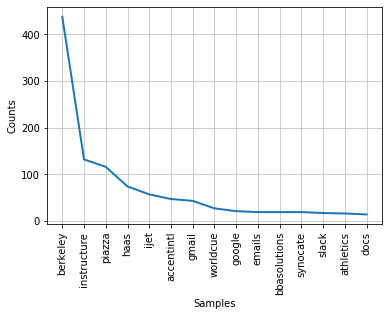

In [9]:
fdist = FreqDist(data["From"])
fdist.plot(15, cumulative=False)
plt.show()

In [15]:
tokenizer = RegexpTokenizer('[^\d\W]+')
cv = CountVectorizer(lowercase=True, stop_words='english', ngram_range = (1,1), tokenizer=tokenizer.tokenize)
text_counts= cv.fit_transform(data['Email Text'])

In [11]:
test_sizes = []
accuracies = [] # total correct - obv high, as most are correctly negative
precisions = [] # how many selected items are relevant?
recalls = [] # how many relevant items are selected?
for size in range(5, 96):
    X_train, X_test, y_train, y_test = train_test_split(
        text_counts, data['Related'], test_size=size/100, random_state=3)
    test_sizes.append(size)
    clf = MultinomialNB().fit(X_train, y_train)
    predicted= clf.predict(X_test)
    accuracies.append(metrics.accuracy_score(y_test, predicted))
    precisions.append(metrics.precision_score(y_test, predicted))
    recalls.append(metrics.recall_score(y_test, predicted))
    #could also show precision and the 4-way table

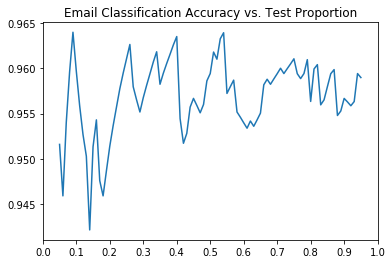

In [186]:
plt.plot([i/100 for i in test_sizes], accuracies)
plt.title("Email Classification Accuracy vs. Test Proportion")
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.show()

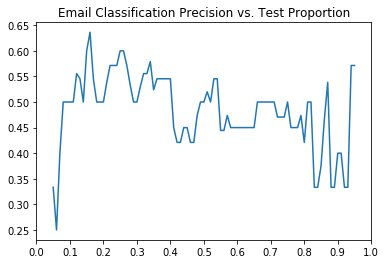

In [185]:
plt.plot([i/100 for i in test_sizes], precisions)
plt.title("Email Classification Precision vs. Test Proportion")
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.show()

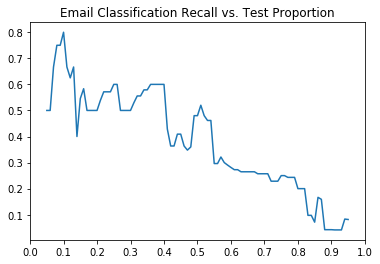

In [187]:
plt.plot([i/100 for i in test_sizes], recalls)
plt.title("Email Classification Recall vs. Test Proportion")
plt.xticks(np.arange(0, 1.1, step=0.1))
plt.show()